In [13]:
# https://www.kaggle.com/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset/data?select=Frog

In [14]:
# =========================
# 1) Config umum
# =========================
DATA_ROOT = "dataset_balance"   # ganti kalau beda
IMG_SIZE = 224
BATCH_SIZE = 32

# Model yang akan dibandingkan (bisa tambah/hapus)
MODEL_NAMES = [
    "vit_base_patch16_224",
    "swin_tiny_patch4_window7_224",
    # "deit_small_patch16_224",
    # "resnet50",  # baseline CNN opsional
]

# Hyperparameter
EPOCHS = 25
WARMUP_EPOCHS = 1
LR = 3e-4
WEIGHT_DECAY = 5e-2
PATIENCE = 4   # early stopping

print("Using:", device)
print("Compare models:", MODEL_NAMES)

Using: cpu
Compare models: ['vit_base_patch16_224', 'swin_tiny_patch4_window7_224']


In [15]:
import os

BASE = "dataset_balanced"
SPLITS = ["train", "val", "test"]

# deteksi kelas dari split yang sudah ada (prioritaskan test)
classes = None
for split in ["test", "train", "val"]:
    split_dir = os.path.join(BASE, split)
    if os.path.isdir(split_dir):
        sub = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        if sub:
            classes = sorted(sub)
            break

if not classes:
    raise RuntimeError("Tidak menemukan kelas pada split mana pun. Pastikan minimal 'test/' berisi folder per kelas.")

print("Kelas terdeteksi:", classes)

# pastikan semua split punya folder kelas yang sama
for split in SPLITS:
    split_dir = os.path.join(BASE, split)
    os.makedirs(split_dir, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

print("✅ Struktur folder sudah dirapikan.")


Kelas terdeteksi: ['Chameleon', 'Frog', 'Iguana', 'Snake', 'Turtle_Tortoise']
✅ Struktur folder sudah dirapikan.


In [16]:
import os

BASE = "dataset_balanced"
for split in ["train", "val", "test"]:
    print(f"\n[{split}]")
    for cls in sorted(os.listdir(os.path.join(BASE, split))):
        cls_dir = os.path.join(BASE, split, cls)
        if os.path.isdir(cls_dir):
            n = len([f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))])
            print(f"  {cls:18s}: {n}")



[train]
  Chameleon         : 140
  Frog              : 140
  Iguana            : 140
  Snake             : 140
  Turtle_Tortoise   : 140

[val]
  Chameleon         : 30
  Frog              : 30
  Iguana            : 30
  Snake             : 30
  Turtle_Tortoise   : 30

[test]
  Chameleon         : 30
  Frog              : 30
  Iguana            : 30
  Snake             : 30
  Turtle_Tortoise   : 30


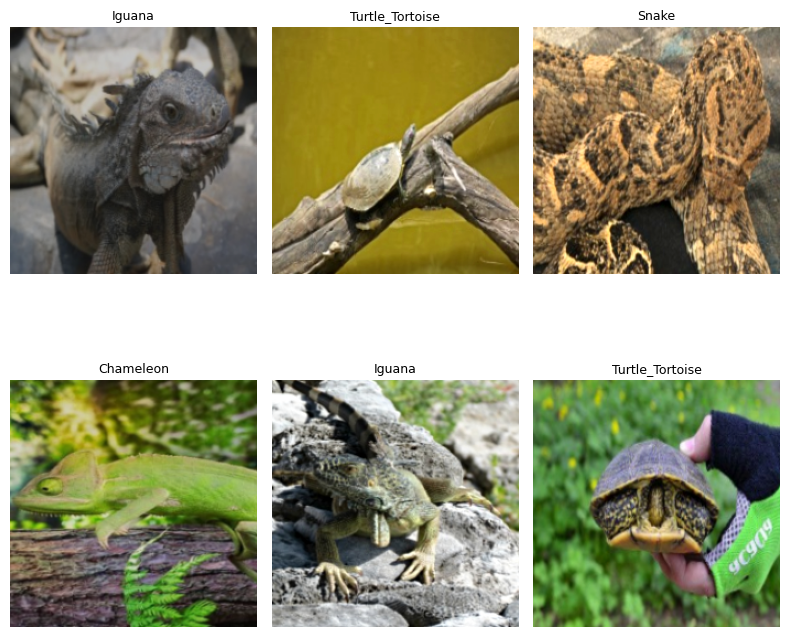

In [17]:
# ==========================================
# 3) Preview: grid beberapa gambar dari train
# ==========================================
def show_batch(dl, n=6):
    x, y = next(iter(dl))
    x, y = x[:n], y[:n]
    plt.figure(figsize=(8,8))
    rows = int(np.sqrt(n)); cols = int(np.ceil(n/rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = x[i].permute(1,2,0).numpy()
        plt.imshow(img); plt.axis('off')
        plt.title(class_names[y[i].item()], fontsize=9)
    plt.tight_layout(); plt.show()

show_batch(train_loader, n=6)


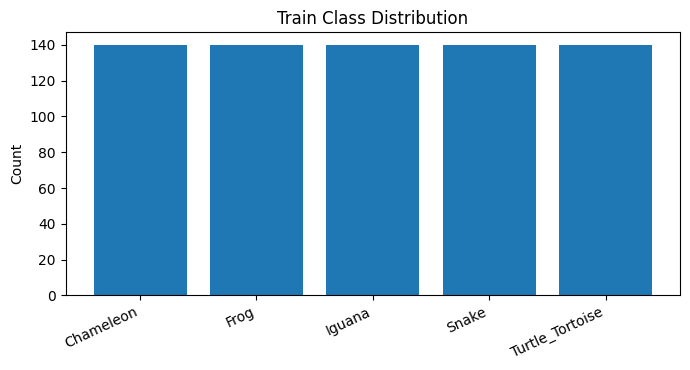

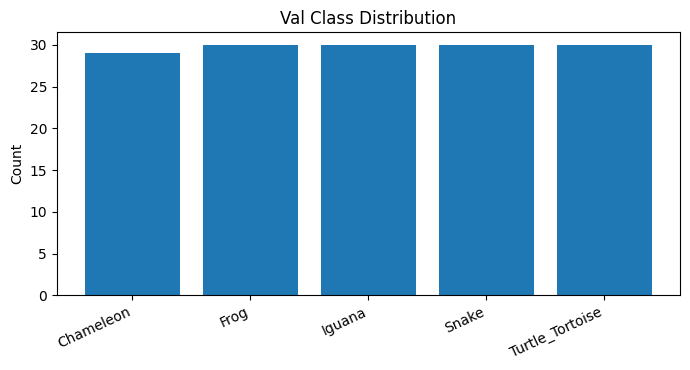

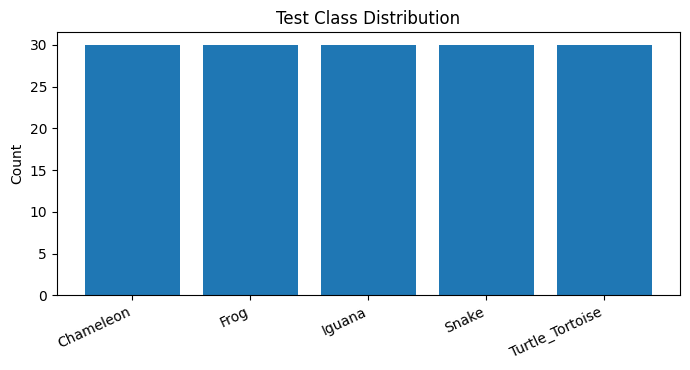

In [18]:
# ==========================================
# 4) Distribusi kelas (train/val/test)
# ==========================================
def count_per_class(ds):
    # ImageFolder menyimpan ds.samples = [(path, label), ...]
    labels = [label for _, label in ds.samples]
    return Counter(labels)

def plot_dist(counter, title):
    plt.figure(figsize=(7,3.8))
    xs = list(range(num_classes))
    ys = [counter.get(i, 0) for i in xs]
    plt.bar(xs, ys)
    plt.xticks(xs, class_names, rotation=25, ha='right')
    plt.ylabel("Count"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_dist(count_per_class(train_ds), "Train Class Distribution")
plot_dist(count_per_class(val_ds),   "Val Class Distribution")
plot_dist(count_per_class(test_ds),  "Test Class Distribution")


In [20]:
# ===========================================================
# 5) Helper: EarlyStopping, epoch runner, dan model factory
# ===========================================================
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.counter = 0
        self.stop = False
    def step(self, metric):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

def create_model(name, num_classes):
    model = timm.create_model(name, pretrained=True, num_classes=num_classes)
    return model.to(device)

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_targets = [], []
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        if train_mode: optimizer.zero_grad()
        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = criterion(logits, y)
            if train_mode:
                loss.backward()
                optimizer.step()
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())
    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_targets)

def train_and_eval(model_name):
    model = create_model(model_name, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=max(EPOCHS - WARMUP_EPOCHS, 1)
    )

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    early = EarlyStopper(patience=PATIENCE, min_delta=1e-4)
    best_state, best_val = None, 1e9

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        if ep > WARMUP_EPOCHS:
            scheduler.step()
        va_loss, va_acc, va_preds, va_trg = run_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"[{model_name}] Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        early.step(va_loss)
        if early.stop:
            print("Early stopping.")
            break

    # load best on val
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    # final test
    test_loss, test_acc, test_preds, test_trg = run_epoch(model, test_loader, criterion, optimizer=None)

    return {
        "name": model_name,
        "model": model,
        "history": history,
        "val_best_loss": best_val,
        "test_loss": test_loss,
        "test_acc":  test_acc,
        "test_preds": test_preds,
        "test_trg":   test_trg,
        "classes": class_names,
    }


In [24]:
# =========================
# 6) Jalankan perbandingan
# =========================
del tqdm
from tqdm import tqdm
results = []
for name in MODEL_NAMES:
    out = train_and_eval(name)
    results.append(out)

print("\n=== Ringkasan singkat ===")
for r in results:
    print(f"{r['name']}: test_acc={r['test_acc']:.4f}, test_loss={r['test_loss']:.4f}, val_best_loss={r['val_best_loss']:.4f}")

[vit_base_patch16_224] Epoch 01 | train 2.0316/0.167 | val 1.6255/0.201


[vit_base_patch16_224] Epoch 02 | train 1.6903/0.209 | val 1.6644/0.208


[vit_base_patch16_224] Epoch 03 | train 1.7015/0.160 | val 1.6687/0.215


[vit_base_patch16_224] Epoch 04 | train 1.6634/0.199 | val 1.6390/0.208


[vit_base_patch16_224] Epoch 05 | train 1.6400/0.229 | val 1.6325/0.268
Early stopping.


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

[swin_tiny_patch4_window7_224] Epoch 01 | train 0.6908/0.730 | val 0.5192/0.872


[swin_tiny_patch4_window7_224] Epoch 02 | train 0.2829/0.904 | val 0.3879/0.872


[swin_tiny_patch4_window7_224] Epoch 03 | train 0.1665/0.943 | val 0.5912/0.839


[swin_tiny_patch4_window7_224] Epoch 04 | train 0.1147/0.969 | val 0.4439/0.886


[swin_tiny_patch4_window7_224] Epoch 05 | train 0.1629/0.946 | val 0.5328/0.859


[swin_tiny_patch4_window7_224] Epoch 06 | train 0.1041/0.966 | val 0.4535/0.872
Early stopping.



=== Ringkasan singkat ===
vit_base_patch16_224: test_acc=0.2133, test_loss=1.6184, val_best_loss=1.6255
swin_tiny_patch4_window7_224: test_acc=0.9333, test_loss=0.2131, val_best_loss=0.3879


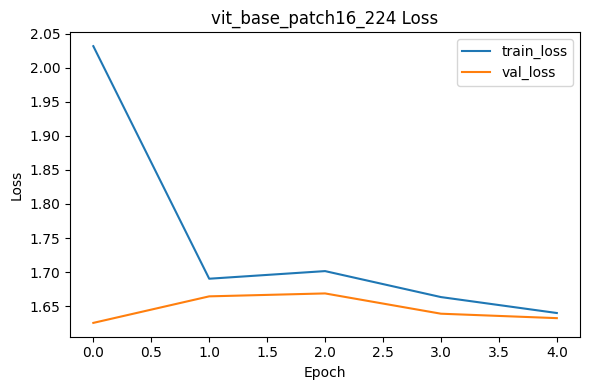

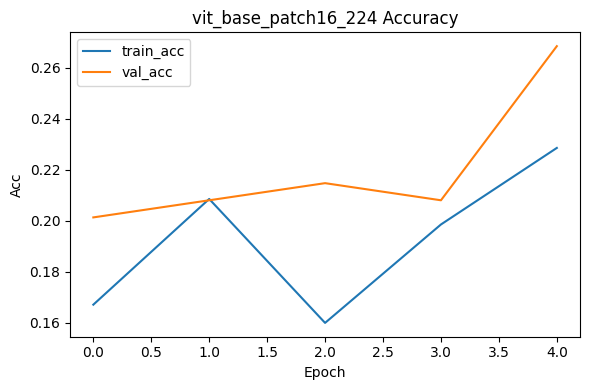

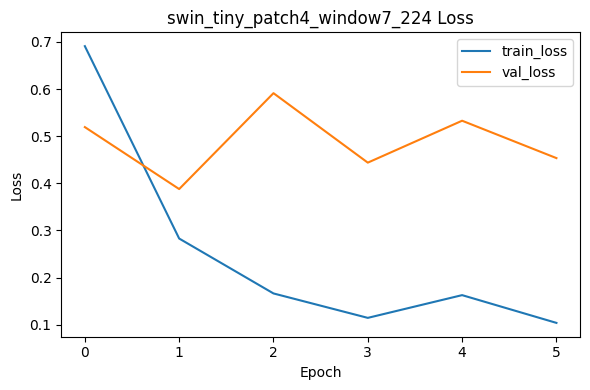

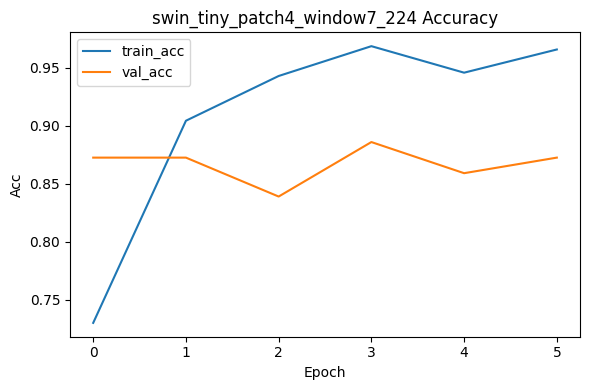

In [25]:
# ===================================
# 7) Plot kurva loss & acc per model
# ===================================
def plot_curves(history, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
    plt.legend(); plt.tight_layout(); plt.show()

for r in results:
    plot_curves(r["history"], title_prefix=r["name"])


Best model: swin_tiny_patch4_window7_224 Test Acc: 0.9333333333333333
Classification report:
                 precision    recall  f1-score   support

      Chameleon     0.8485    0.9333    0.8889        30
           Frog     1.0000    1.0000    1.0000        30
         Iguana     0.8333    0.8333    0.8333        30
          Snake     1.0000    1.0000    1.0000        30
Turtle_Tortoise     1.0000    0.9000    0.9474        30

       accuracy                         0.9333       150
      macro avg     0.9364    0.9333    0.9339       150
   weighted avg     0.9364    0.9333    0.9339       150



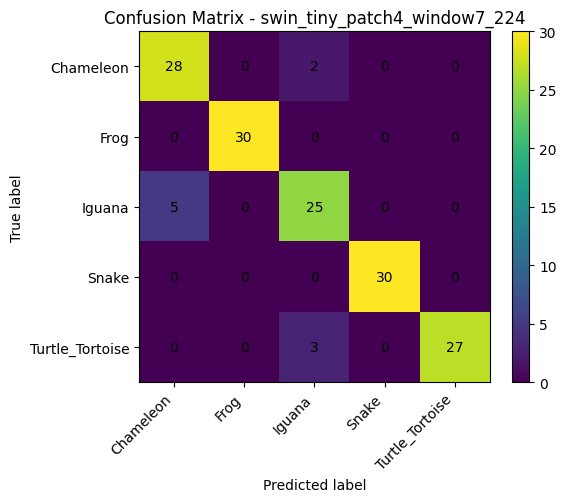

In [26]:
# ==========================================================
# 8) Confusion Matrix + Classification Report (best model)
# ==========================================================
best = max(results, key=lambda x: x["test_acc"])
print("Best model:", best["name"], "Test Acc:", best["test_acc"])

cm = confusion_matrix(best["test_trg"], best["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(best["test_trg"], best["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {best['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# anotasi angka per sel
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")

plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout(); plt.show()


worst model: vit_base_patch16_224 Test Acc: 0.21333333333333335
Classification report:
                 precision    recall  f1-score   support

      Chameleon     0.1908    0.8333    0.3106        30
           Frog     0.0000    0.0000    0.0000        30
         Iguana     0.0000    0.0000    0.0000        30
          Snake     0.3333    0.2000    0.2500        30
Turtle_Tortoise     1.0000    0.0333    0.0645        30

       accuracy                         0.2133       150
      macro avg     0.3048    0.2133    0.1250       150
   weighted avg     0.3048    0.2133    0.1250       150



c:\Users\hp\miniconda3\envs\triathlon\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hp\miniconda3\envs\triathlon\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hp\miniconda3\envs\triathlon\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

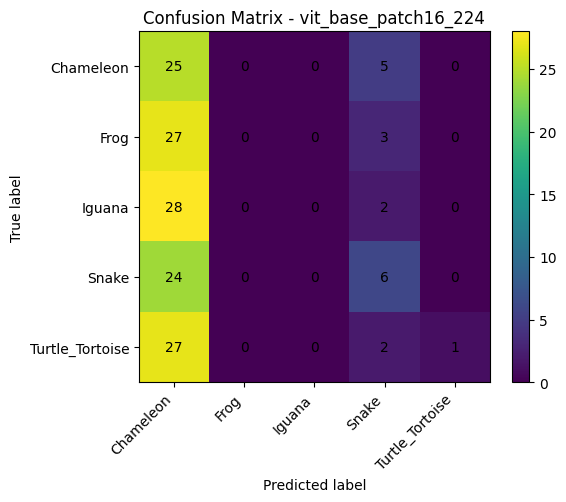

In [ ]:
# ==========================================================
# 8.1) Confusion Matrix + Classification Report (worst model)
# ==========================================================
worst = min(results, key=lambda x: x["test_acc"])
print("worst model:", worst["name"], "Test Acc:", worst["test_acc"])

cm = confusion_matrix(worst["test_trg"], worst["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(worst["test_trg"], worst["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {worst['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# anotasi angka per sel
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")

plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout(); plt.show()


In [27]:
# ==========================================
# 9) Latency & Throughput untuk tiap model
# ==========================================
def benchmark_inference(model, loader, n_runs=20):
    model.eval()
    x,_ = next(iter(loader))
    x = x.to(device)
    # warmup
    with torch.inference_mode():
        _ = model(x)
    times = []
    for _ in range(n_runs):
        start = time.time()
        with torch.inference_mode():
            _ = model(x)
        times.append(time.time() - start)
    batch_time = float(np.mean(times))
    per_image_ms = (batch_time / x.size(0)) * 1000.0
    throughput = x.size(0) / batch_time
    return batch_time, per_image_ms, throughput

bench = {}
for r in results:
    bt, ms, th = benchmark_inference(r["model"], test_loader)
    bench[r["name"]] = {"batch_s": bt, "per_image_ms": ms, "throughput": th}

bench


{'vit_base_patch16_224': {'batch_s': 5.9808236956596375,
  'per_image_ms': 186.90074048936367,
  'throughput': 5.35043359048066},
 'swin_tiny_patch4_window7_224': {'batch_s': 2.8309358835220335,
  'per_image_ms': 88.46674636006355,
  'throughput': 11.303682356870638}}

In [29]:
# ==========================================
# 10) Tabel ringkasan hasil (akurasi & speed)
# ==========================================
import pandas as pd

rows = []
for r in results:
    rows.append({
        "model": r["name"],
        "test_acc": r["test_acc"],
        "test_loss": r["test_loss"],
        "val_best_loss": r["val_best_loss"],
        "batch_s": bench[r["name"]]["batch_s"],
        "per_image_ms": bench[r["name"]]["per_image_ms"],
        "throughput_img_s": bench[r["name"]]["throughput"],
    })

df = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
df


,model,test_acc,test_loss,val_best_loss,batch_s,per_image_ms,throughput_img_s
0,swin_tiny_patch4_window7_224,0.933333,0.213115,0.387851,2.830936,88.466746,11.303682
1,vit_base_patch16_224,0.213333,1.618360,1.625500,5.980824,186.900740,5.350434


In [30]:
# ==========================================
# 11) Simpan model terbaik & CSV ringkasan
# ==========================================
best = max(results, key=lambda x: x["test_acc"])
save_path = f"best_{best['name']}.pt"
torch.save({
    "state_dict": best["model"].state_dict(),
    "classes": class_names,
    "img_size": IMG_SIZE,
    "model_name": best["name"]
}, save_path)

df.to_csv("results_summary.csv", index=False)

print("Saved model to:", save_path)
print("Saved results to: results_summary.csv")


Saved model to: best_swin_tiny_patch4_window7_224.pt
Saved results to: results_summary.csv
